<a href="https://colab.research.google.com/github/homata123/machine-learning/blob/master/7/8/21_GAN%2BDiff%2BFID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [3]:
cd /content/gdrive/My Drive/Kaggle

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Kaggle'
/content


In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [6]:
#!kaggle competitions download -c generative-dog-images
!kaggle datasets download -d homata123/vnceleb

 98% 625M/638M [00:06<00:00, 99.4MB/s]
100% 638M/638M [00:06<00:00, 100MB/s] 


In [7]:
!unzip vnceleb.zip

Streaming output truncated to the last 5000 lines.
  inflating: VN-celeb/785/21.png     
  inflating: VN-celeb/785/22.png     
  inflating: VN-celeb/785/23.png     
  inflating: VN-celeb/785/24.png     
  inflating: VN-celeb/785/25.png     
  inflating: VN-celeb/785/26.png     
  inflating: VN-celeb/785/27.png     
  inflating: VN-celeb/785/28.png     
  inflating: VN-celeb/785/29.png     
  inflating: VN-celeb/785/3.png      
  inflating: VN-celeb/785/30.png     
  inflating: VN-celeb/785/4.png      
  inflating: VN-celeb/785/5.png      
  inflating: VN-celeb/785/6.png      
  inflating: VN-celeb/785/7.png      
  inflating: VN-celeb/785/8.png      
  inflating: VN-celeb/785/9.png      
  inflating: VN-celeb/786/0.png      
  inflating: VN-celeb/786/1.png      
  inflating: VN-celeb/786/10.png     
  inflating: VN-celeb/786/11.png     
  inflating: VN-celeb/786/2.png      
  inflating: VN-celeb/786/3.png      
  inflating: VN-celeb/786/4.png      
  inflating: VN-celeb/786/5.png      

In [9]:
!cd /content

100%|██████████| 7/7 [00:00<00:00, 482.67it/s]


Number of samples: 3418
(3418, 128, 128, 3)
3418


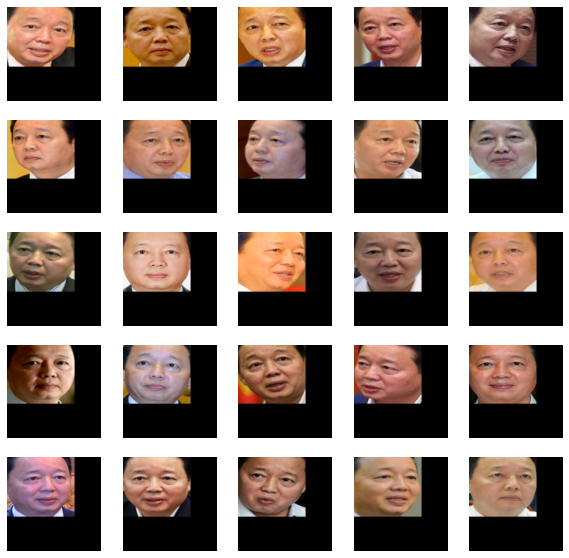

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


<class 'tensorflow.python.framework.ops.EagerTensor'>


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf



from DiffAugment_tf import DiffAugment
policy = 'color,translation,cutout'
PIC_DIR = f'/content/VN-celeb'
    
from tqdm import tqdm
from PIL import Image

IMAGES_COUNT = 150

ORIG_WIDTH = 178
ORIG_HEIGHT = 208
diff = (ORIG_HEIGHT - ORIG_WIDTH) // 2

WIDTH = 128
HEIGHT = 128

crop_rect = (0, diff, ORIG_WIDTH, ORIG_HEIGHT - diff)

images = []
number_of_samples=0
for fold in os.listdir(PIC_DIR)[:IMAGES_COUNT]:
  #for pic_file in tqdm(os.listdir(PIC_DIR)[:IMAGES_COUNT]):
  fold1=os.path.join(PIC_DIR,fold)
  for pic_file in tqdm(os.listdir(fold1)):
      fold2=os.path.join(fold1,pic_file)
      pic = Image.open(fold2).crop(crop_rect)
      pic.thumbnail((WIDTH, HEIGHT), Image.ANTIALIAS)
      images.append(np.uint8(pic))
      number_of_samples+=1
print("Number of samples:",number_of_samples)



images = np.array(images) / 255
print(images.shape)
#
print(images.shape[0])
#

from matplotlib import pyplot as plt


#Code cell <XJuaS7xBEd4C>
# %% [code]

plt.figure(1, figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


#Code cell <V8Qq_kWLEeaG>
# %% [code]

from keras import Input
from keras.layers import Dense, Reshape, LeakyReLU, Conv2D, Conv2DTranspose, Flatten, Dropout
from keras.models import Model
from keras.optimizers import RMSprop
import math

LATENT_DIM = 32
CHANNELS = 3


#Code cell <m1NzuOZ4EkZ->
# %% [code]

def create_generator():
    gen_input = Input(shape=(LATENT_DIM, ))

    x = Dense(128 * 16 * 16)(gen_input)
    x = LeakyReLU()(x)
    x = Reshape((16, 16, 128))(x)

    x = Conv2D(256, 5, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(512, 5, padding='same')(x)
    x = LeakyReLU()(x)
    x = Conv2D(CHANNELS, 7, activation='tanh', padding='same')(x)

    generator = Model(gen_input, x)
    return generator

def create_discriminator():
    disc_input = Input(shape=(HEIGHT, WIDTH, CHANNELS))

    x = Conv2D(256, 3)(disc_input)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2)(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dropout(0.4)(x)

    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(disc_input, x)

    optimizer = RMSprop(
        lr=.0001,
        clipvalue=1.0,
        decay=1e-8
    )

    discriminator.compile(
        optimizer=optimizer,
        loss='binary_crossentropy'
    )

    return discriminator



generator = create_generator()
discriminator = create_discriminator()
discriminator.trainable = False


#Code cell <z_j5727aEqV_>
# %% [code]

gan_input = Input(shape=(LATENT_DIM, ))
gan_output = discriminator(generator(gan_input))
gan = Model(gan_input, gan_output)

optimizer = RMSprop(lr=.0001, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=optimizer, loss='binary_crossentropy')


#calculate FID

from scipy import linalg
from scipy.linalg import sqrtm
    



def calculate_fid(real_embeddings, generated_embeddings):
     # calculate mean and covariance statistics
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
    mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)
     # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = linalg.sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
     # calculate score
    small_fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return small_fid
#Code cell <PKTtwEbbEyL2>
# %% [code]

import time
from tqdm import tqdm
from sklearn.decomposition import PCA
import math
pca_dimension=36
pca_dimension_sqrt=int(math.sqrt(pca_dimension))
pca = PCA(n_components=pca_dimension)
iters = 500
batch_size = 16

RES_DIR = 'res2'
FILE_PATH = '%s/generated_%d.png'
if not os.path.isdir(RES_DIR):
    os.mkdir(RES_DIR)

CONTROL_SIZE_SQRT = 6
control_vectors = np.random.normal(size=(CONTROL_SIZE_SQRT**2, LATENT_DIM)) / 2
fid=[]
start = 0
d_losses = []
a_losses = []
images_saved = 0
for step in range(iters):
    start_time = time.time()
    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    generated0 = generator.predict(latent_vectors)

    real0 = images[start:start + batch_size]
    #
    real=DiffAugment(real0, policy=policy)
    print(type(real))
    generated=DiffAugment(generated0, policy=policy)
    #2 lines below for non-diffAugment 
    #real=real0
    #generated=generated0
    #
    combined_images = np.concatenate([generated, real])

    labels = np.concatenate([np.ones(((batch_size), 1)), np.zeros(((batch_size), 1))])
    labels += .05 * np.random.random(labels.shape)

    d_loss = discriminator.train_on_batch(combined_images, labels)
    d_losses.append(d_loss)

    latent_vectors = np.random.normal(size=(batch_size, LATENT_DIM))
    misleading_targets = np.zeros((batch_size, 1))

    a_loss = gan.train_on_batch(latent_vectors, misleading_targets)
    a_losses.append(a_loss)
    
    #
    real_image_embeddings = []
    generated_image_embeddings=[]
    count=int(number_of_samples/batch_size)
    for i in range(len(real0)):
        imagei = real0[i].reshape((1,128,128,3))
        r_embeddings = discriminator.predict(imagei)
        
        real_image_embeddings.extend(r_embeddings)
    
        imagei1 = generated0[i].reshape((1,128,128,3))
        g_embeddings = discriminator.predict(imagei1)
        generated_image_embeddings.extend(g_embeddings)
    
    
    #print("gen",generated_image_embeddings)
    #print("real",real_image_embeddings)
    sqrt_real=int(math.sqrt(len(real_image_embeddings)))
    sqrt_gen=int(math.sqrt(len(generated_image_embeddings)))
    gen_em=np.reshape(generated_image_embeddings,(sqrt_gen,sqrt_gen))
    real_em=np.reshape(real_image_embeddings,(sqrt_real,sqrt_real))    
    #
    start += batch_size
    
    if start > images.shape[0] - batch_size:
        start = 0

    if step % 20 == 19:
        gan.save_weights('/content/drive/MyDrive/gan.h5')

        print('%d/%d: d_loss: %.4f,  a_loss: %.4f.  (%.1f sec)' % (step + 1, iters, d_loss, a_loss, time.time() - start_time))

        control_image = np.zeros((WIDTH * CONTROL_SIZE_SQRT, HEIGHT * CONTROL_SIZE_SQRT, CHANNELS))
        control_generated = generator.predict(control_vectors)
        for i in range(CONTROL_SIZE_SQRT ** 2):
            x_off = i % CONTROL_SIZE_SQRT
            y_off = i // CONTROL_SIZE_SQRT
            control_image[x_off * WIDTH:(x_off + 1) * WIDTH, y_off * HEIGHT:(y_off + 1) * HEIGHT, :] = control_generated[i, :, :, :]
        im = Image.fromarray(np.uint8(control_image * 255))
        im.save(FILE_PATH % (RES_DIR, images_saved))
        images_saved += 1
        fid.append(calculate_fid(real_em,gen_em))
        

plt.figure(1, figsize=(12, 8))
plt.subplot(221)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(222)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()
plt.subplot(223)
weight_step=[]
for i in range(1,iters):
  if i%20==0 or i==iters-1:

    weight_step.append(i)
plt.plot(weight_step,fid)
plt.xlabel('epochs')
plt.ylabel('FID')
plt.show()
print(fid)
print("FID size",len(fid))

import imageio
import shutil

images_to_gif = []
for filename in os.listdir(RES_DIR):
    images_to_gif.append(imageio.imread(RES_DIR + '/' + filename))
imageio.mimsave('visual.gif', images_to_gif)
shutil.rmtree(RES_DIR)

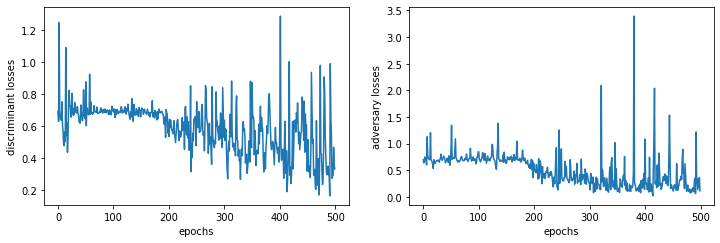

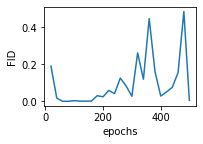

[0.18996426204732172, 0.01721201943504435, 0.00031776723113536816, 0.0001861263559697347, 0.0037061956980132815, 0.001179986192423621, 0.001050115485276878, 0.001512041353206381, 0.030351869736525688, 0.0243952273763818, 0.05861875398854921, 0.0419982854715129, 0.12566414054007588, 0.0834293790130321, 0.0275020985118372, 0.2617614173769861, 0.11953738215235254, 0.44700893929869395, 0.16118703216555186, 0.028569331874805034, 0.05099554893973005, 0.0757730335168307, 0.15518671772306283, 0.48542500991131543, 0.0056788110095331735]
FID size 25


In [ ]:
plt.figure(1, figsize=(12, 8))
plt.subplot(221)
plt.plot(d_losses)
plt.xlabel('epochs')
plt.ylabel('discriminant losses')
plt.subplot(222)
plt.plot(a_losses)
plt.xlabel('epochs')
plt.ylabel('adversary losses')
plt.show()
plt.subplot(223)
weight_step=[]
for i in range(1,iters):
  if i%20==0 or i==iters-1:

    weight_step.append(i)
plt.plot(weight_step,fid)
plt.xlabel('epochs')
plt.ylabel('FID')
plt.show()
print(fid)
print("FID size",len(fid))

In [ ]:
plt.figure(1, figsize=(10, 10))

for filename in os.listdir(RES_DIR):
    i=imageio.imread(RES_DIR + '/' + filename)
    plt.subplot(5, 5, i+1)
    plt.imshow([i])
    plt.axis('off')
plt.show()

FileNotFoundError: ignored

<Figure size 720x720 with 0 Axes>